In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Normalization, BatchNormalization, Dropout, LeakyReLU, ELU, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3, efficientnet_v2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC


dataset_folder = "/content/drive/MyDrive/Agricultural-crops"


image_paths = []
labels = []
classes = os.listdir(dataset_folder)
n_classes = len(classes)
for c in classes:
    class_folder = dataset_folder + "/" + c
    for image in os.listdir(class_folder):
        image_path = class_folder + "/" + image
        image_paths.append(image_path)
        labels.append(c)

df = pd.DataFrame({"image_path": image_paths, "label": labels})


train_df, val_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=666)


datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    shear_range=0.1,
    channel_shift_range=0.1
)

ts = 224 ; # 384


train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)
tf.test.is_gpu_available()

Found 580 validated image filenames belonging to 30 classes.
Found 249 validated image filenames belonging to 30 classes.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
val_df

,image_path,label
547,/content/drive/MyDrive/Agricultural-crops/jute...,jute
793,/content/drive/MyDrive/Agricultural-crops/clov...,clove
673,/content/drive/MyDrive/Agricultural-crops/Cucu...,Cucumber
279,/content/drive/MyDrive/Agricultural-crops/papa...,papaya
269,/content/drive/MyDrive/Agricultural-crops/rice...,rice
...,...,...
88,/content/drive/MyDrive/Agricultural-crops/whea...,wheat
633,/content/drive/MyDrive/Agricultural-crops/bana...,banana
646,/content/drive/MyDrive/Agricultural-crops/bana...,banana
235,/content/drive/MyDrive/Agricultural-crops/soya...,soyabean


In [ ]:
import matplotlib.pyplot as plt
import time



base_model = keras.applications.MobileNet(
    input_shape=(ts, ts, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=n_classes,
    pooling=None,
)


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
])


optimizer = optimizers.RMSprop(learning_rate=0.0008 )



model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1.0e-15)
checkpoint = ModelCheckpoint('model{"val_loss":.2f}.h5', monitor=model.compiled_metrics, verbose=0, save_best_only=True, mode='max')
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005, decay_rate=0.5, decay_steps=1, staircase=True)
cos_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


inicio = time.time()
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=4, # 8
    validation_data=val_generator,
    callbacks=[early_stopping]
)
# Grava o tempo final
fim = time.time()

# Calcula o tempo total decorrido
tempo_total = fim - inicio
print(f"Tempo de execução: {tempo_total} segundos")



total_params = model.count_params()





17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/20
19/19 [==============================] - 355s 19s/step - loss: 4.4291 - accuracy: 0.0397 - val_loss: 3.3594 - val_accuracy: 0.0562
Epoch 2/20
19/19 [==============================] - 53s 3s/step - loss: 4.0464 - accuracy: 0.0379 - val_loss: 3.2660 - val_accuracy: 0.0683
Epoch 3/20
19/19 [==============================] - 53s 3s/step - loss: 3.7565 - accuracy: 0.0707 - val_loss: 3.1284 - val_accuracy: 0.1365
Epoch 4/20
19/19 [==============================] - 53s 3s/step - loss: 3.6809 - accuracy: 0.0914 - val_loss: 3.1289 - val_accuracy: 0.1245
Epoch 5/20
19/19 [==============================] - 53s 3s/step - loss: 3.5141 - accuracy: 0.1121 - val_loss: 2.9796 - val_accuracy: 0.1767
Epoch 6/20
19/19 [==============================] - 53s 3s/step - loss: 3.5218 - accuracy: 0.0931 - val_loss: 2.9350 - val_accuracy: 0.1888
Epoch 7/20
19/19 [==============================] - 47s 2s/step - loss: 3.2267 - accuracy: 0.

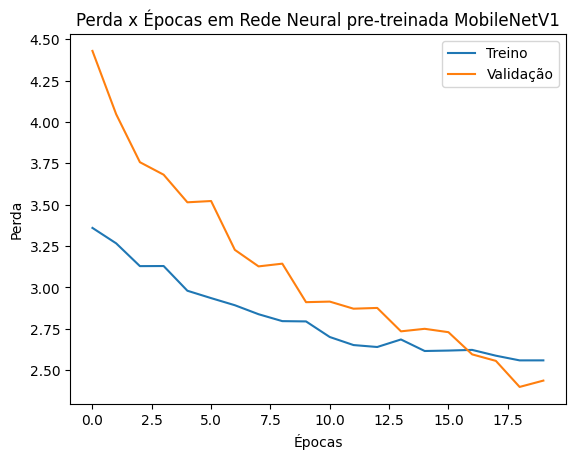

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Perda x Épocas em Rede Neural pre-treinada MobileNetV1')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig('plot_salvato.png')
plt.show()

Key: loss, Value: [4.429073810577393, 4.0463690757751465, 3.7565231323242188, 3.680891752243042, 3.514101028442383, 3.5218045711517334, 3.2266602516174316, 3.1267547607421875, 3.143235445022583, 2.9105215072631836, 2.913937568664551, 2.871084690093994, 2.8756165504455566, 2.734187602996826, 2.7494707107543945, 2.729099750518799, 2.5949668884277344, 2.555598735809326, 2.3982415199279785, 2.4364752769470215]
Key: accuracy, Value: [0.0396551713347435, 0.037931036204099655, 0.07068965584039688, 0.0913793072104454, 0.11206896603107452, 0.09310344606637955, 0.1310344785451889, 0.16206896305084229, 0.15000000596046448, 0.19310344755649567, 0.19137930870056152, 0.19655172526836395, 0.1948275864124298, 0.2068965584039688, 0.24137930572032928, 0.22758620977401733, 0.23620688915252686, 0.2586206793785095, 0.31206896901130676, 0.2810344696044922]
Key: val_loss, Value: [3.359367609024048, 3.2659919261932373, 3.128355026245117, 3.1289288997650146, 2.979604482650757, 2.9350032806396484, 2.89203119277

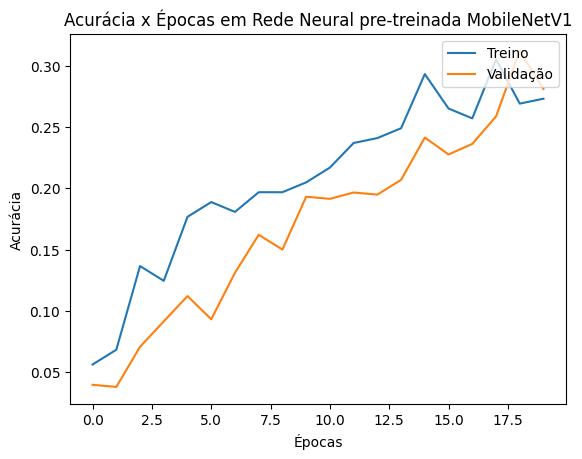

In [ ]:
for key, value in (history.history.items()):
    print(f'Key: {key}, Value: {value}')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Acurácia x Épocas em Rede Neural pre-treinada MobileNetV1')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()